## $\kappa$-velo visualisation on simulation

In this notebook we will apply our $\kappa$-velo method to a simulation. More specifically, in this notebook we are interested in the visualisation of the velocities, which is one of the steps in the $\kappa$-velo workflow. You can use this notebook to reproduce figures 1A,B,D and S4A-F. 

In [1]:
### load libraries

# general libraries
import numpy as np

# single cell libraries
import scvelo as scv

# plotting libraries
import matplotlib.pyplot as plt

# dimension reduction libraries
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
import umap

# other
from scipy.spatial import cKDTree #for projection onto existing t-SNE

# import our own functions
from functions import *
from projection import *
from simulation import *

In [2]:
### set scvelo settings
scv.settings.verbosity = 0 

### Generate simulation data

Here, we generate a simulated dataset that we will use to test $\kappa$-velo's visualisation approach on. We use scVelo's function `scvelo.datasets.simulation` to create the simulation. The simulated dataset has 25 genes and 2850 cells with parameters $\alpha$, $\beta$ and $\gamma$ scaled by a scaling factor $\kappa$ between 1 and 15. Finally, we use our function `get_velocity` to calculate the ground truth velocities using the true parameters. 

In [3]:
### set random seed
np.random.seed(3)

### set variables
n_vars, n_obs, t_max, noise_level = 25, 3000, 10, 1
switches = np.arange(.9, 0.999, (.999-.9)/n_vars)
start_t = None

### set parameters alpha, beta gamma
mu = np.array([1, .2, .05])
R = np.array([[1., .2, .2], [.2, 1., .2], [.2, .2, 1.]])
C = np.array([0.2, 0.2, 0.2])[:, None]
cov = C.dot(C.T) * R
alpha, beta, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T)  # multivariate log-normal
beta /= 3
gamma /= 3

### scale genes to different time scales (kappa)
max_kappa = 15
min_kappa = 1
kappa = np.random.uniform(min_kappa, max_kappa, n_vars)
kappa[0:3]=1
alpha, beta, gamma, switches = alpha*kappa, beta*kappa, gamma*kappa, switches

### create simulation dataset
adata = simulation(n_obs=n_obs, t_max=t_max, n_vars=n_vars, noise_level=noise_level, alpha=alpha, beta=beta, gamma=gamma, switches=switches, start_t=start_t)

### remove first 150 cells
adata = adata[0:n_obs-150].copy()
scv.pp.neighbors(adata)

### recover true velocities
get_velocity(adata, key="true")

### Visualisation of velocities (scVelo vs $\kappa$-velo)

Here, we visualise the true velocities using scVelo's approach and our $\kappa$-velo approach. First, we calculate an embedding using the spliced counts (.X). Then, we use either scVelo or $\kappa$-velo to project the velocities onto the existing embedding. We compare the two approaches on PCA, t-SNE, diffusion map, and UMAP embeddings. 

### (I) PCA 

These figures correspond to Figure 1A and 1B in the manuscript.

In [4]:
### calculate PCA embedding
pca = PCA(n_components=2, copy=True)
pc = pca.fit(adata.X)
data = pc.transform(adata.X)

In [5]:
### our projection approach
zero = pca.transform(np.zeros((1,n_vars)))
v_t = (pca.transform(adata.layers["velocity"]*5)-zero)

In [6]:
### scvelo projection approach
adata.obsm["X_pca"]=data
bdata = adata.copy()
scv.tl.velocity_graph(bdata)
scv.tl.velocity_embedding(bdata, "pca")#, scale=0.10)
v_0 = bdata.obsm["velocity_pca"][:,0:2]
v_0/=np.std(v_0)
v_0*=np.std(v_t)

In [7]:
### select cells to highlight
step = 5
idx_first = 600
sub = np.arange(600, adata.shape[0], step) 

cell = data[idx_first+step*5]
dist = np.sum((data[sub]-cell)**2, axis=1)
sub_slow = sub[np.argsort(dist)[0:45]] #sample cells at very beginning of trajectory

cell = data[idx_first+step*410]
dist = np.sum((data[sub]-cell)**2, axis=1)
sub_fast = sub[np.argsort(dist)[0:20]] 

In [8]:
### set arguments for plotting
main_plot_aspect_ratio = (8, 6)
pltkwargs={"figsize":main_plot_aspect_ratio, "frameon":False}
akwargs = {"head_width":.2, "head_length":.2, "alpha":.6, "width":0.001, "color":"black"}
(dim1, dim2) = (0, 1)
vecs = [v_t, v_0]

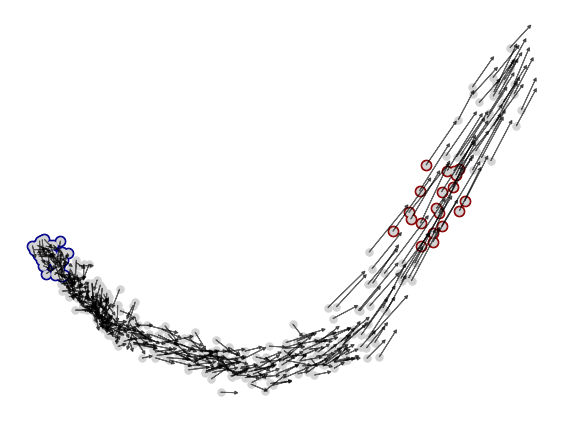

In [9]:
### create PCA plot (kappa-velo visualisation)
fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs:
        ax.scatter(data[sub,dim1]+v_[sub, dim1], data[sub,dim2]+v_[sub, dim2], s=1, color="white")
ax.scatter(data[sub,dim1], data[sub,dim2], s=55, color="lightgrey")
ax.scatter(data[sub_slow,dim1], data[sub_slow,dim2], s=115, color="darkblue")
ax.scatter(data[sub_slow,dim1], data[sub_slow,dim2], s=55, color="lightgrey")
ax.scatter(data[sub_fast,dim1], data[sub_fast,dim2], s=115, color="darkred")
ax.scatter(data[sub_fast,dim1], data[sub_fast,dim2], s=55, color="lightgrey")
ax.axis("off")

for i in sub:
    ax.arrow(data[i,dim1], data[i,dim2], dx=v_t[i,dim1], dy=v_t[i,dim2], **akwargs)

fig.tight_layout()

# save figure
save_path = "../figures/Fig2A_PCA_simulation_kappa-velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

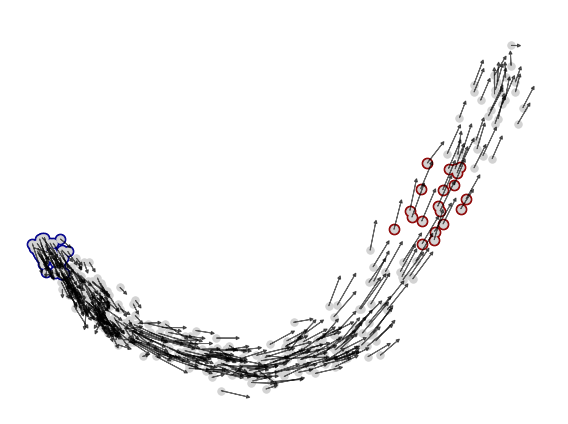

In [10]:
### create PCA plot (scVelo visualisation)
fig, ax = plt.subplots(1, 1, **pltkwargs)
for v_ in vecs:
        ax.scatter(data[sub,dim1]+v_[sub, dim1], data[sub,dim2]+v_[sub, dim2], s=1, color="white")
ax.scatter(data[sub,dim1], data[sub,dim2], s=55, color="lightgrey")
ax.scatter(data[sub_slow,dim1], data[sub_slow,dim2], s=115, color="darkblue")
ax.scatter(data[sub_slow,dim1], data[sub_slow,dim2], s=55, color="lightgrey")
ax.scatter(data[sub_fast,dim1], data[sub_fast,dim2], s=115, color="darkred")
ax.scatter(data[sub_fast,dim1], data[sub_fast,dim2], s=55, color="lightgrey")
ax.axis("off")

for i in sub:
    ax.arrow(data[i,dim1], data[i,dim2], 
             dx=v_0[i,dim1], dy=v_0[i,dim2], #color="darkred", 
             **akwargs)

fig.tight_layout()

# save figure
save_path = "../figures/Fig2B_PCA_simulation_scVelo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

### (II) t-SNE

These figures correspond to Figure 1D in the manuscript and Figure S4A and S4B in the Supplementary Figures.

In [11]:
### calculate PCA
sc.pp.pca(adata)

In [12]:
### set seed
np.random.seed(1)

### calculate t-SNE embedding
pca_transform = adata.varm["PCs"]
X_ = np.dot(adata.X, pca_transform)
d2 = pairwise_distances(X_, metric="euclidean")
data = TSNE(n_components=2, random_state=2, metric="precomputed", perplexity=60).fit_transform(d2)

In [28]:
### calculate projection of velocities onto embedding (kappa-velo method)
k = 50
use_raw=True
velocity_down_scale=0.2

NN = cKDTree(X_).query(x=X_, k=k, n_jobs=1)[1]
pca_transform = adata.varm["PCs"]
X_ = np.dot(adata.layers["spliced" if use_raw else "Ms"], pca_transform)
d2 = pairwise_distances(X_, metric="euclidean")
P_proj = tsne_d2p_NN(d2, NN, row_norm=True)
W = nystrom(P_proj, data)

# get transportation to future states
X2 = np.dot(adata.layers["spliced" if use_raw else "Ms"]+(adata.layers["velocity"]/velocity_down_scale), pca_transform)
d2 = pairwise_distances(X2, X_, metric="euclidean")

NN = cKDTree(X_).query(x=X2, k=k, n_jobs=1)[1]
P_2 = tsne_d2p_NN(d2, NN)
v_t = (np.dot(P_2, W)-data)

In [29]:
### calculate projection of velocities onto embedding (scVelo method)
adata.obsm["X_tsne"]=data
bdata = adata.copy()
scv.tl.velocity_graph(bdata)
scv.tl.velocity_embedding(bdata, "tsne")
v_scvelo = bdata.obsm["velocity_tsne"][:,0:2] # velocities from scvelo

v_scvelo/=np.std(v_scvelo) # scale to same range for ease of comparison
v_scvelo*=np.std(v_t)

In [30]:
### select only part of the cells to avoid overcrowding the t-SNE
step = 5
sub = np.arange(310, adata.shape[0], step)

In [31]:
### set arguments for plotting
akwargs = {"head_width":.9, "head_length":1, "alpha":.9, "width":0.01, "color":"black"}
pltkwargs={"figsize":(6, 6), "frameon":False}
(dim1, dim2) = (0, 1)

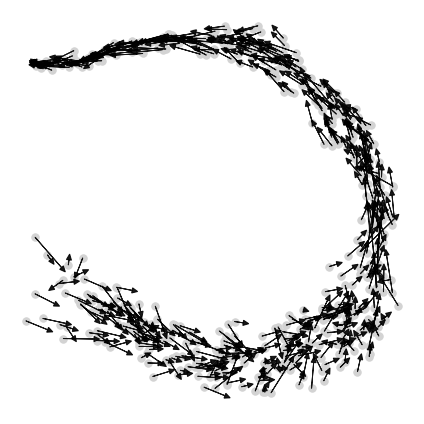

In [32]:
### create t-SNE plot (kappa-velo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)

ax.scatter(data[sub,dim1], data[sub,dim2], s=55, color="lightgrey")
ax.axis("off")

for i in sub:
    ax.arrow(data[i,dim1], data[i,dim2], dx=v_t[i,dim1], dy=v_t[i,dim2], **akwargs)

fig.tight_layout()

# save figure
save_path = "../figures/FigS4A_tSNE_simulation_kappa-velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)
save_path = "../figures/Fig2D_tSNE_simulation_kappa-velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

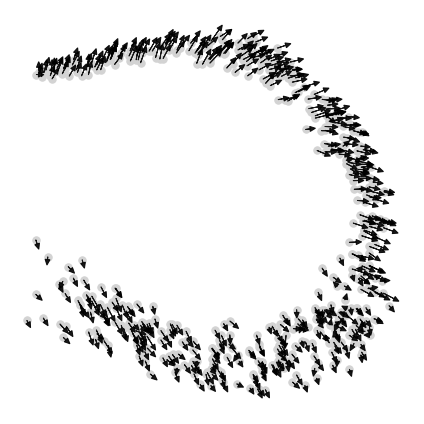

In [33]:
### create t-SNE plot (scVelo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)
ax.scatter(data[sub,dim1], data[sub,dim2], s=55, color="lightgrey")
ax.axis("off")

for i in sub:
    ax.arrow(data[i,dim1], data[i,dim2], 
             dx=v_0[i,dim1], dy=v_0[i,dim2], #color="darkred", 
             **akwargs)

fig.tight_layout()

# save figure
save_path = "../figures/FigS4B_tSNE_simulation_scVelo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

### (III) diffusion map

These figures correspond to Figure S4C and S4D in the Supplementary Figures.

In [34]:
### calculate diffusion map embedding
sigma = 20
evals, evecs, z_x = diffmap_eigen(adata, sigma=sigma)

In [35]:
### calculate projection of velocities onto embedding (kappa-velo method)
data = evecs
pca_transform = adata.varm["PCs"]
v_t = add_proj(adata.X, adata.X+(adata.layers["velocity"]/2), evecs, evals, sigma, z_x,pca_transform)-data

In [36]:
### calculate projection of velocities onto embedding (scVelo method)
adata.obsm["X_diffmap_own"]=data[:,1:3]
bdata = adata.copy()
scv.tl.velocity_graph(bdata)
scv.tl.velocity_embedding(bdata, "diffmap_own")#, scale=0.10)
v_0 = bdata.obsm["velocity_diffmap_own"]#[:,0:3]
v_0/=np.std(v_0)
v_0*=np.std(v_t)

In [37]:
### set arguments for plotting
pltkwargs={"figsize":(9, 6), "frameon":False}
akwargs = {"head_width":.0005, "head_length":.0005, "alpha":.6, "width":0.00001, "color":"black"}
(dim1, dim2) = (1, 2)

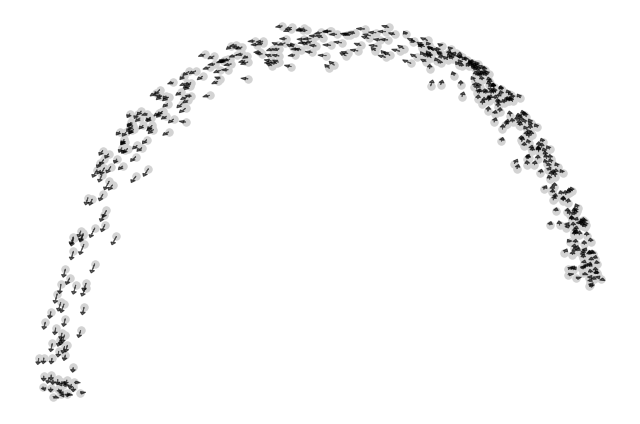

In [39]:
### create diffusion map plot (kappa-velo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)

ax.scatter(data[sub,dim1], data[sub,dim2], s=55, color="lightgrey")
ax.axis("off")

for i in sub:
    ax.arrow(data[i,dim1], data[i,dim2], dx=v_t[i,dim1], dy=v_t[i,dim2], **akwargs)

fig.tight_layout()

# save figure
save_path = "../figures/FigS4C_diffmap_simulation_kappa-velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

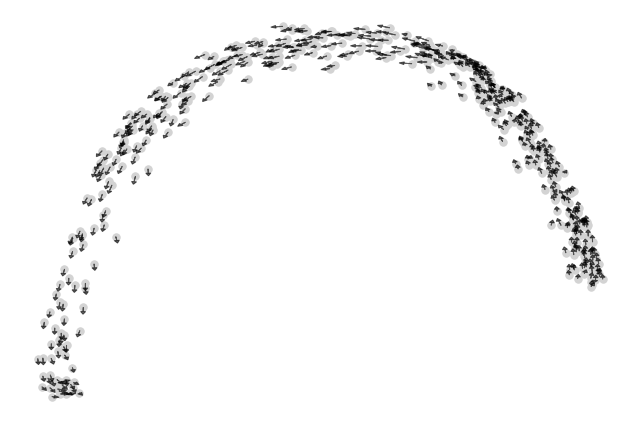

In [40]:
### create diffusion map plot (scVelo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)
ax.scatter(data[sub,dim1], data[sub,dim2], s=55, color="lightgrey")
ax.axis("off")

for i in sub:
    ax.arrow(data[i,dim1], data[i,dim2], 
             dx=v_0[i,dim1-1], dy=v_0[i,dim2-1], #color="darkred", 
             **akwargs)

fig.tight_layout()

# save figure
save_path = "../figures/FigS4D_diffmap_simulation_scVelo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

### (IV) UMAP

These figures correspond to Figure S4E and S4F in the Supplementary Figures.

In [41]:
### calculate diffusion map embedding
reducer = umap.UMAP(random_state=2, n_components=2, metric="euclidean", min_dist=.5)
embedding = reducer.fit_transform(adata.layers["spliced"])

In [42]:
### calculate projection of velocities onto embedding (scVelo method)
adata.obsm["X_umap"]=embedding
scv.tl.velocity_graph(adata)
scv.tl.velocity_embedding(adata, "umap")
v_0 = adata.obsm["velocity_umap"][:,0:2]

In [43]:
### calculate projection of velocities onto embedding (kappa-velo method)
W = nystrom(P_proj, embedding)
v_t = (np.dot(P_2, W)-embedding)/2
v_0/=np.std(v_0)
v_0*=np.std(v_t)

In [44]:
### set arguments for plotting
akwargs = {"head_width":.15, "head_length":.15, "alpha":.6, "width":0.01, "color":"black"}
pltkwargs={"figsize":(6, 6), "frameon":False}
(dim1, dim2) = (0, 1)

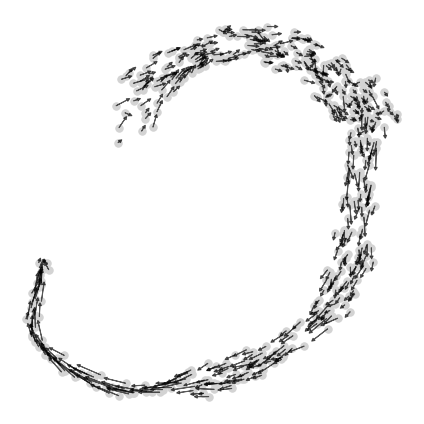

In [45]:
### create UMAP plot (kappa-velo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)

ax.scatter(embedding[sub,dim1], embedding[sub,dim2], s=55, color="lightgrey")
ax.axis("off")

for i in sub:
    ax.arrow(embedding[i,dim1], embedding[i,dim2], dx=v_t[i,dim1], dy=v_t[i,dim2], **akwargs)

fig.tight_layout()

# save figure
save_path = "../figures/FigS4E_UMAP_simulation_kappa-velo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

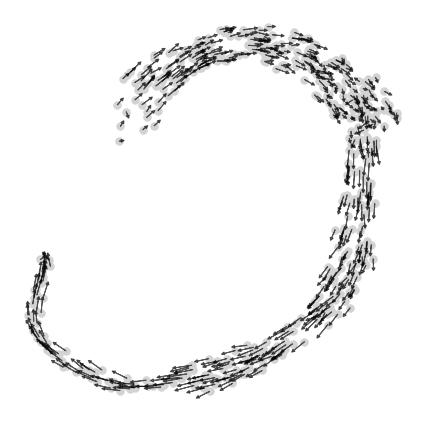

In [46]:
### create UMAP plot (scVelo visualisation) 
fig, ax = plt.subplots(1, 1, **pltkwargs)
ax.scatter(embedding[sub,dim1], embedding[sub,dim2], s=55, color="lightgrey")
ax.axis("off")

for i in sub:
    ax.arrow(embedding[i,dim1], embedding[i,dim2], 
             dx=v_0[i,dim1], dy=v_0[i,dim2], #color="darkred", 
             **akwargs)

fig.tight_layout()

# save figure
save_path = "../figures/FigS4F_UMAP_simulation_scVelo.pdf"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()